Check the running torch version

In [1]:
import torch
torch.__version__

'1.2.0'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required

# Download and explore iam dataset

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import sys
sys.path.append('..')

import toml

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())  # Source: https://github.com/fastai/fastai/blob/master/fastai/core.py#L236

from tqdm import tqdm

from PIL import Image

In [4]:
from src.datasets import Dataset

In [5]:
lines_detector_path = Dataset.processed_data_path()/"lines-segmentation"
lines_detector_images_path = lines_detector_path/"images"
lines_detector_masks_path = lines_detector_path/"masks"

lines_detector_images_path.mkdir(parents=True, exist_ok=True)
lines_detector_masks_path.mkdir(parents=True, exist_ok=True)

In [6]:
path = Dataset.raw_data_path()/"iam"

In [7]:
path.ls()

[PosixPath('/home/jupyter/lines-segmentation-pytorch/data/raw/iam/readme.md'),
 PosixPath('/home/jupyter/lines-segmentation-pytorch/data/raw/iam/metadata.toml')]

In [8]:
!cat {path}/metadata.toml

url = 'https://s3-us-west-2.amazonaws.com/fsdl-public-assets/iam/iamdb.zip'
filename = 'iamdb.zip'
sha256 = 'f3c9e87a88a313e557c6d3548ed8a2a1af2dc3c4a678c5f3fc6f972ba4a50c55'


## Download dataset

In [9]:
metadata = toml.load(path/"metadata.toml")
metadata

{'url': 'https://s3-us-west-2.amazonaws.com/fsdl-public-assets/iam/iamdb.zip',
 'filename': 'iamdb.zip',
 'sha256': 'f3c9e87a88a313e557c6d3548ed8a2a1af2dc3c4a678c5f3fc6f972ba4a50c55'}

In [10]:
Path(metadata["filename"]).stem

'iamdb'

In [11]:
cache_path = Dataset.cache_data_path()/"datasets"
cache_path.mkdir(parents=True, exist_ok=True)

data_path = cache_path/Path(metadata["filename"]).stem
if not data_path.exists():
    print(">> Download iam dataset")
    !wget -O {cache_path/metadata['filename']} {metadata['url']}
    print(">> Unzip it")
    !unzip {cache_path/metadata['filename']} -d {cache_path}
    print(">> Done")
else:
    print("Data already downloaded")

>> Download iam dataset
--2019-09-12 18:54:15--  https://s3-us-west-2.amazonaws.com/fsdl-public-assets/iam/iamdb.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 54.231.176.204
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|54.231.176.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 614648402 (586M) [application/zip]
Saving to: ‘/home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb.zip’

/home/jupyter/lines 100%[===================>] 586.17M  10.4MB/s    in 99s     

2019-09-12 18:55:55 (5.91 MB/s) - ‘/home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb.zip’ saved [614648402/614648402]

>> Unzip it
Archive:  /home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb.zip
   creating: /home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb/
   creating: /home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb/ascii/
  inflating: /home/jupyter/lines-segmentat

In [12]:
data_path.ls()

[PosixPath('/home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb/ascii'),
 PosixPath('/home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb/xml'),
 PosixPath('/home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb/forms'),
 PosixPath('/home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb/.DS_Store'),
 PosixPath('/home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb/task')]

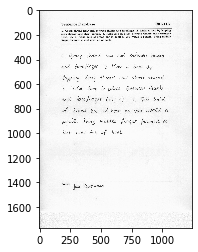

In [13]:
image = Image.open(data_path/"forms"/"e01-113.jpg")
plt.imshow(image, cmap="gray")

## Explore dataset

In [14]:
import xml.etree.ElementTree as ElementTree
from typing import Dict, List

DOWNSAMPLE_FACTOR = 2  # If images were downsampled, the regions must also be.
LINE_REGION_PADDING = 0  # add this many pixels around the exact coordinates

def get_image_file_name_from_xml_file(filename: str) -> str:
    """Get the image file name."""
    xml_root_element = ElementTree.parse(filename).getroot()  # nosec
    return xml_root_element.attrib['id'] + ".jpg"

def get_line_strings_from_xml_file(filename: str) -> List[str]:
    """Get the text content of each line. Note that we replace &quot; with "."""
    xml_root_element = ElementTree.parse(filename).getroot()  # nosec
    xml_line_elements = xml_root_element.findall('handwritten-part/line')
    return [el.attrib['text'].replace('&quot;', '"') for el in xml_line_elements]

def get_line_regions_from_xml_file(filename: str) -> List[Dict[str, int]]:
    """Get the line region dict for each line."""
    xml_root_element = ElementTree.parse(filename).getroot()  # nosec
    xml_line_elements = xml_root_element.findall('handwritten-part/line')
    return [_get_line_region_from_xml_element(el) for el in xml_line_elements]


def _get_line_region_from_xml_element(xml_line) -> Dict[str, int]:
    """
    line (xml element): has x, y, width, and height attributes
    """
    word_elements = xml_line.findall('word/cmp')
    x1s = [int(el.attrib['x']) for el in word_elements]
    y1s = [int(el.attrib['y']) for el in word_elements]
    x2s = [int(el.attrib['x']) + int(el.attrib['width']) for el in word_elements]
    y2s = [int(el.attrib['y']) + int(el.attrib['height']) for el in word_elements]
    return {
        'x1': min(x1s) // DOWNSAMPLE_FACTOR - LINE_REGION_PADDING,
        'y1': min(y1s) // DOWNSAMPLE_FACTOR - LINE_REGION_PADDING,
        'x2': max(x2s) // DOWNSAMPLE_FACTOR + LINE_REGION_PADDING,
        'y2': max(y2s) // DOWNSAMPLE_FACTOR + LINE_REGION_PADDING
    }

In [15]:
xml_files = list((data_path / "xml").glob("*.xml"))
len(xml_files)

1539

In [16]:
index = 0
xml_file_name = xml_files[index]
xml_file_name

PosixPath('/home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb/xml/h07-007.xml')

In [17]:
xml_file_name.stem, xml_file_name.suffix

('h07-007', '.xml')

In [18]:
get_image_file_name_from_xml_file(xml_file_name)

'h07-007.jpg'

In [19]:
get_line_strings_from_xml_file(xml_file_name)

['There is no reason to suppose that this pattern is peculiar to',
 'Crawley. The development corporations have aimed at a varied',
 'pattern of industry, offering a reasonable choice of',
 'employer as well as choice of occupation for men, women and',
 'school-leavers, with due regard to the industries',
 'already established in their towns. Inevitably engineering,',
 'including the motor vehicle and aircraft industries,',
 'predominates in all the London new towns since these are',
 'among the industries which have expanded most',
 'during the last ten years in the country generally.']

In [20]:
get_line_regions_from_xml_file(xml_file_name)

[{'x1': 165, 'y1': 375, 'x2': 1070, 'y2': 416},
 {'x1': 171, 'y1': 464, 'x2': 1103, 'y2': 504},
 {'x1': 174, 'y1': 556, 'x2': 1001, 'y2': 596},
 {'x1': 170, 'y1': 646, 'x2': 1114, 'y2': 687},
 {'x1': 175, 'y1': 737, 'x2': 1007, 'y2': 773},
 {'x1': 174, 'y1': 823, 'x2': 1120, 'y2': 865},
 {'x1': 170, 'y1': 911, 'x2': 1054, 'y2': 952},
 {'x1': 167, 'y1': 1005, 'x2': 1091, 'y2': 1035},
 {'x1': 168, 'y1': 1093, 'x2': 1017, 'y2': 1135},
 {'x1': 168, 'y1': 1184, 'x2': 1039, 'y2': 1221}]

### Plot some images with lines overlay

In [21]:
def plot_image_with_lines_overlay(xml_file_name):
    x = Image.open(data_path/"forms"/get_image_file_name_from_xml_file(xml_file_name))
    y = get_line_regions_from_xml_file(xml_file_name)

    fig, ax = plt.subplots(1, figsize=(20, 10))
    ax.imshow(x, cmap='gray')

    for index, line in enumerate(y, 1):
        width = line['x2'] - line['x1']
        height = line['y2'] - line['y1']
        color = "red" if index % 2 == 0 else "blue"
        
        rect = patches.Rectangle(xy=(line['x1'], line['y1']), width=width, height=height, alpha=0.5, facecolor=color)
        ax.add_patch(rect)

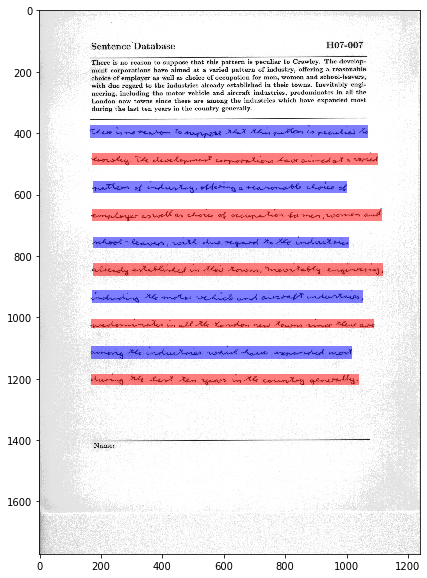

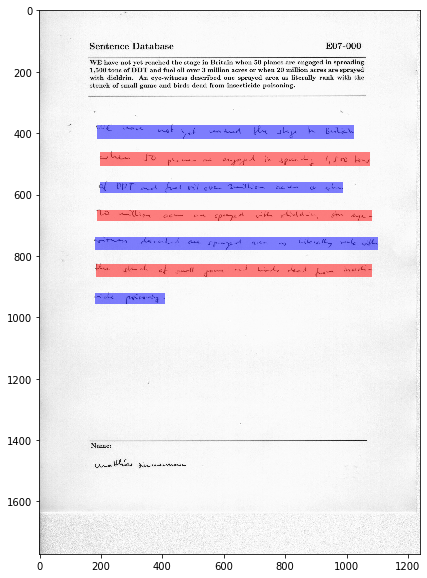

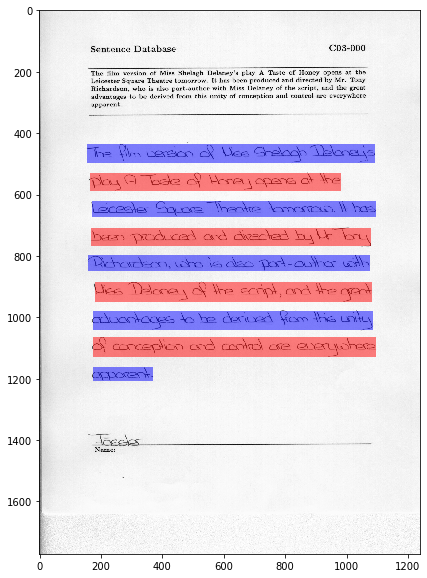

In [22]:
plot_image_with_lines_overlay(xml_files[0])
plot_image_with_lines_overlay(xml_files[1])
plot_image_with_lines_overlay(xml_files[2])